In [27]:
import os 
import json
import numpy as np
import pandas as pd
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from collections import defaultdict
import pandas as pd
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import roc_auc_score, mean_squared_error

In [28]:
import os
# Office
os.chdir('C:\\Users\\prudi\\Documents\\GitHub\\Code\\NITDATA\\Algorithms\\codesnippetsforbaggingandboostingalgorithms')
data = pd.read_csv('train_u6lujuX_CVtuZ9i.csv')

In [29]:
from sklearn.base import BaseEstimator, TransformerMixin
import pickle

class PreProcessing(BaseEstimator, TransformerMixin):


    def __init__(self):
        pass

    
    ## Here this model will be called with a variable (df), which is a dataframe
    def datapreprocessing(self, df):
        
        df = df.reset_index(drop=True)
        
        df.loc[df['Gender'].isnull(),'Gender']='Trasgender'
        df.loc[df['Dependents'].isnull(),'Dependents']='0'
        df.loc[df['Education'].isnull(),'Education']='No Education'
        df.loc[df['Married'].isnull(),'Married']='No'
        df.loc[df['Self_Employed'].isnull(),'Self_Employed']='No'
        df.loc[df['Loan_Amount_Term'].isnull(),'Loan_Amount_Term']=0
        df.loc[df['Credit_History'].isnull(),'Credit_History']=0
        df.loc[df['LoanAmount'].isnull(),'LoanAmount']=146.867     
        df['Credit_History']=df['Credit_History'].astype(str)
        
        
        ## Creating a Instance for the minmax Pickle File
        MinMaxpickle_in = open("minmax_pickle.pkl","rb")
        MinmaxScaler_dict = pickle.load(MinMaxpickle_in)
        
        ## Applying the pickle file
        df['ApplicantIncome']=pd.DataFrame(MinmaxScaler_dict['ApplicantIncome'].transform(df[['ApplicantIncome']]))
        
        ## Creating a Instance for the minmax Pickle File
        standardscaler_in = open("standardscaler_pickle.pkl","rb")
        standardscaler_dict = pickle.load(standardscaler_in)
        
        ## Applying the pickle file
        df['LoanAmount']=pd.DataFrame(standardscaler_dict['LoanAmount'].transform(df[['LoanAmount']]))
        
        ## Creating a Instance for the LabelEncoder Pickle File
        Labelencoderpickle_in = open("labelencoder_pickle.pkl","rb")
        Labelencoder_dict = pickle.load(Labelencoderpickle_in)
        
        ## Applying the pickle file
        df['Education']=pd.DataFrame(Labelencoder_dict['Education'].transform(df[['Education']]))
        df['Property_Area']=pd.DataFrame(Labelencoder_dict['Property_Area'].transform(df[['Property_Area']]))
        df['Credit_History']=pd.DataFrame(Labelencoder_dict['Credit_History'].transform(df[['Credit_History']]))
        df['Dependents']=pd.DataFrame(Labelencoder_dict['Dependents'].transform(df[['Dependents']]))
        
        ## Creating a Instance for the binarizer Pickle File
        Onehotpickle_in = open("binarizer_pickle.pkl","rb")
        Onehot_dict = pickle.load(Onehotpickle_in)
        
        ## Applying the pickle file
        d1=pd.DataFrame(Onehot_dict['Self_Employed'].transform(df[['Self_Employed']]))
        d1.columns=['Self_Employed_0']
        d2=pd.DataFrame(Onehot_dict['Married'].transform(df[['Married']]))
        d2.columns=['Married_0']
        d3=pd.DataFrame(Onehot_dict['Gender'].transform(df[['Gender']]))
        d3.columns=['Gender_0','Gender_1','Gender_2']
    
        df=df.drop(['Self_Employed','Married','Gender','Loan_ID'],axis=1)
        df=pd.concat([df,d1,d2,d3],axis=1)
        
        return df

    def definingvalues(self, df, y=None,**fit_params):
        self.term_mean_ = df['Loan_Amount_Term'].mean()
        self.amt_mean_ = df['LoanAmount'].mean()
        return self
    
    def encodingTargetVariable(self,df):
        Labelencoderpickle_in = open("labelencoder_pickle.pkl","rb")
        Labelencoder_dict = pickle.load(Labelencoderpickle_in)
        
        ## Applying the pickle file
        df['Loan_Status']=pd.DataFrame(Labelencoder_dict['Loan_Status'].transform(df[['Loan_Status']]))
        
        return df.as_matrix()

In [30]:
data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [31]:
pred_var = ['Loan_ID','Gender','Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area']
X_train, X_test, y_train, y_test = train_test_split(data[pred_var], data['Loan_Status'], test_size=0.30, random_state=42)

In [32]:
## Creating an instance for the class
preprocess = PreProcessing()

In [33]:
# Calling the fit function present in the class Preprocessing
preprocess.definingvalues(X_train)

PreProcessing()

In [34]:
## Calling the datapreprocessing function present in the class Preprocessing to Preprocess X_train dataset
data_transformed_xtrain = preprocess.datapreprocessing(X_train)

pred_var = ['Dependents', 'Education', 'ApplicantIncome',
       'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History',
       'Property_Area', 'Self_Employed_0', 'Married_0', 'Gender_0', 'Gender_1','Gender_2']


data_transformed_xtrain=pd.DataFrame(data_transformed_xtrain,columns=pred_var)
data_transformed_xtrain.head()

print(data_transformed_xtrain.shape)
print(X_train.shape)

(429, 13)
(429, 12)


In [35]:
data_transformed_xtrain.columns

Index(['Dependents', 'Education', 'ApplicantIncome', 'CoapplicantIncome',
       'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
       'Self_Employed_0', 'Married_0', 'Gender_0', 'Gender_1', 'Gender_2'],
      dtype='object')

In [36]:
## Calling the datapreprocessing function present in the class Preprocessing to Preprocess X_test dataset
data_transformed_xtest = preprocess.datapreprocessing(X_test)

# Converting the matrix to a dataframe
data_transformed_xtest=pd.DataFrame(data_transformed_xtest,columns=pred_var)
data_transformed_xtest.head()

,Dependents,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Self_Employed_0,Married_0,Gender_0,Gender_1,Gender_2
0,0,0,0.681284,0.0,1.426199,360.0,1,1,0,1,0,1,0
1,0,0,0.317267,0.0,-0.108986,360.0,0,1,0,1,0,1,0
2,2,0,0.306361,1447.0,0.329638,360.0,1,0,0,1,0,1,0
3,0,0,0.209732,0.0,-1.033230,360.0,1,0,0,0,1,0,0
4,0,0,0.195851,0.0,-1.048895,360.0,1,1,0,0,0,1,0


In [37]:
y_train=pd.DataFrame(y_train).reset_index(drop=True)
y_train.columns=['Loan_Status']

y_test=pd.DataFrame(y_test).reset_index(drop=True)
y_test.columns=['Loan_Status']

y_train=preprocess.encodingTargetVariable(y_train)
y_test=preprocess.encodingTargetVariable(y_test)

In [38]:
import warnings; warnings.simplefilter('ignore')
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pandas import Series, DataFrame
from sklearn.model_selection import train_test_split, GridSearchCV

parameters1={'max_depth':[2,3,4,6,8,10],'max_features':[2,4,6,8],'min_samples_leaf':[0.1,0.2,0.3],'min_samples_split':[0.1,0.2,0.3]}
dtc=DecisionTreeClassifier()

scoring=['precision','recall']
#scoring = {'AUC': 'roc_auc'}
for score in scoring:
    DTC_gridsearchcv=GridSearchCV(dtc,parameters1,cv=3,scoring='%s_macro' % score)
    DTC_gridsearchcv.fit(data_transformed_xtrain,y_train)
    print('CV Results Keys: \n',DTC_gridsearchcv.cv_results_.keys())
    print('Best Params: ',DTC_gridsearchcv.best_params_)
    print('Best Score: ',DTC_gridsearchcv.best_score_)
    print("Train set score: {:.2f}".format(DTC_gridsearchcv.score(data_transformed_xtrain, y_train)))
    print("Test set score: {:.2f}".format(DTC_gridsearchcv.score(data_transformed_xtest, y_test)))  
    print('*'*50)

CV Results Keys: 
 dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_max_features', 'param_min_samples_leaf', 'param_min_samples_split', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
Best Params:  {'max_depth': 2, 'max_features': 8, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1}
Best Score:  0.7478478558417639
Train set score: 0.73
Test set score: 0.76
**************************************************
CV Results Keys: 
 dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_max_features', 'param_min_samples_leaf', 'param_min_samples_split', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
Best Params:  {'max_depth': 2, 'max_features': 8, 'min_samples_leaf': 0.2, 'min_samples_split': 0.1}
Best Score:  0.683127674

### Before you run the below code
#### Install the below libraries
###### pip install pydotplus
###### conda install python-graphviz

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=1, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=0.1,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


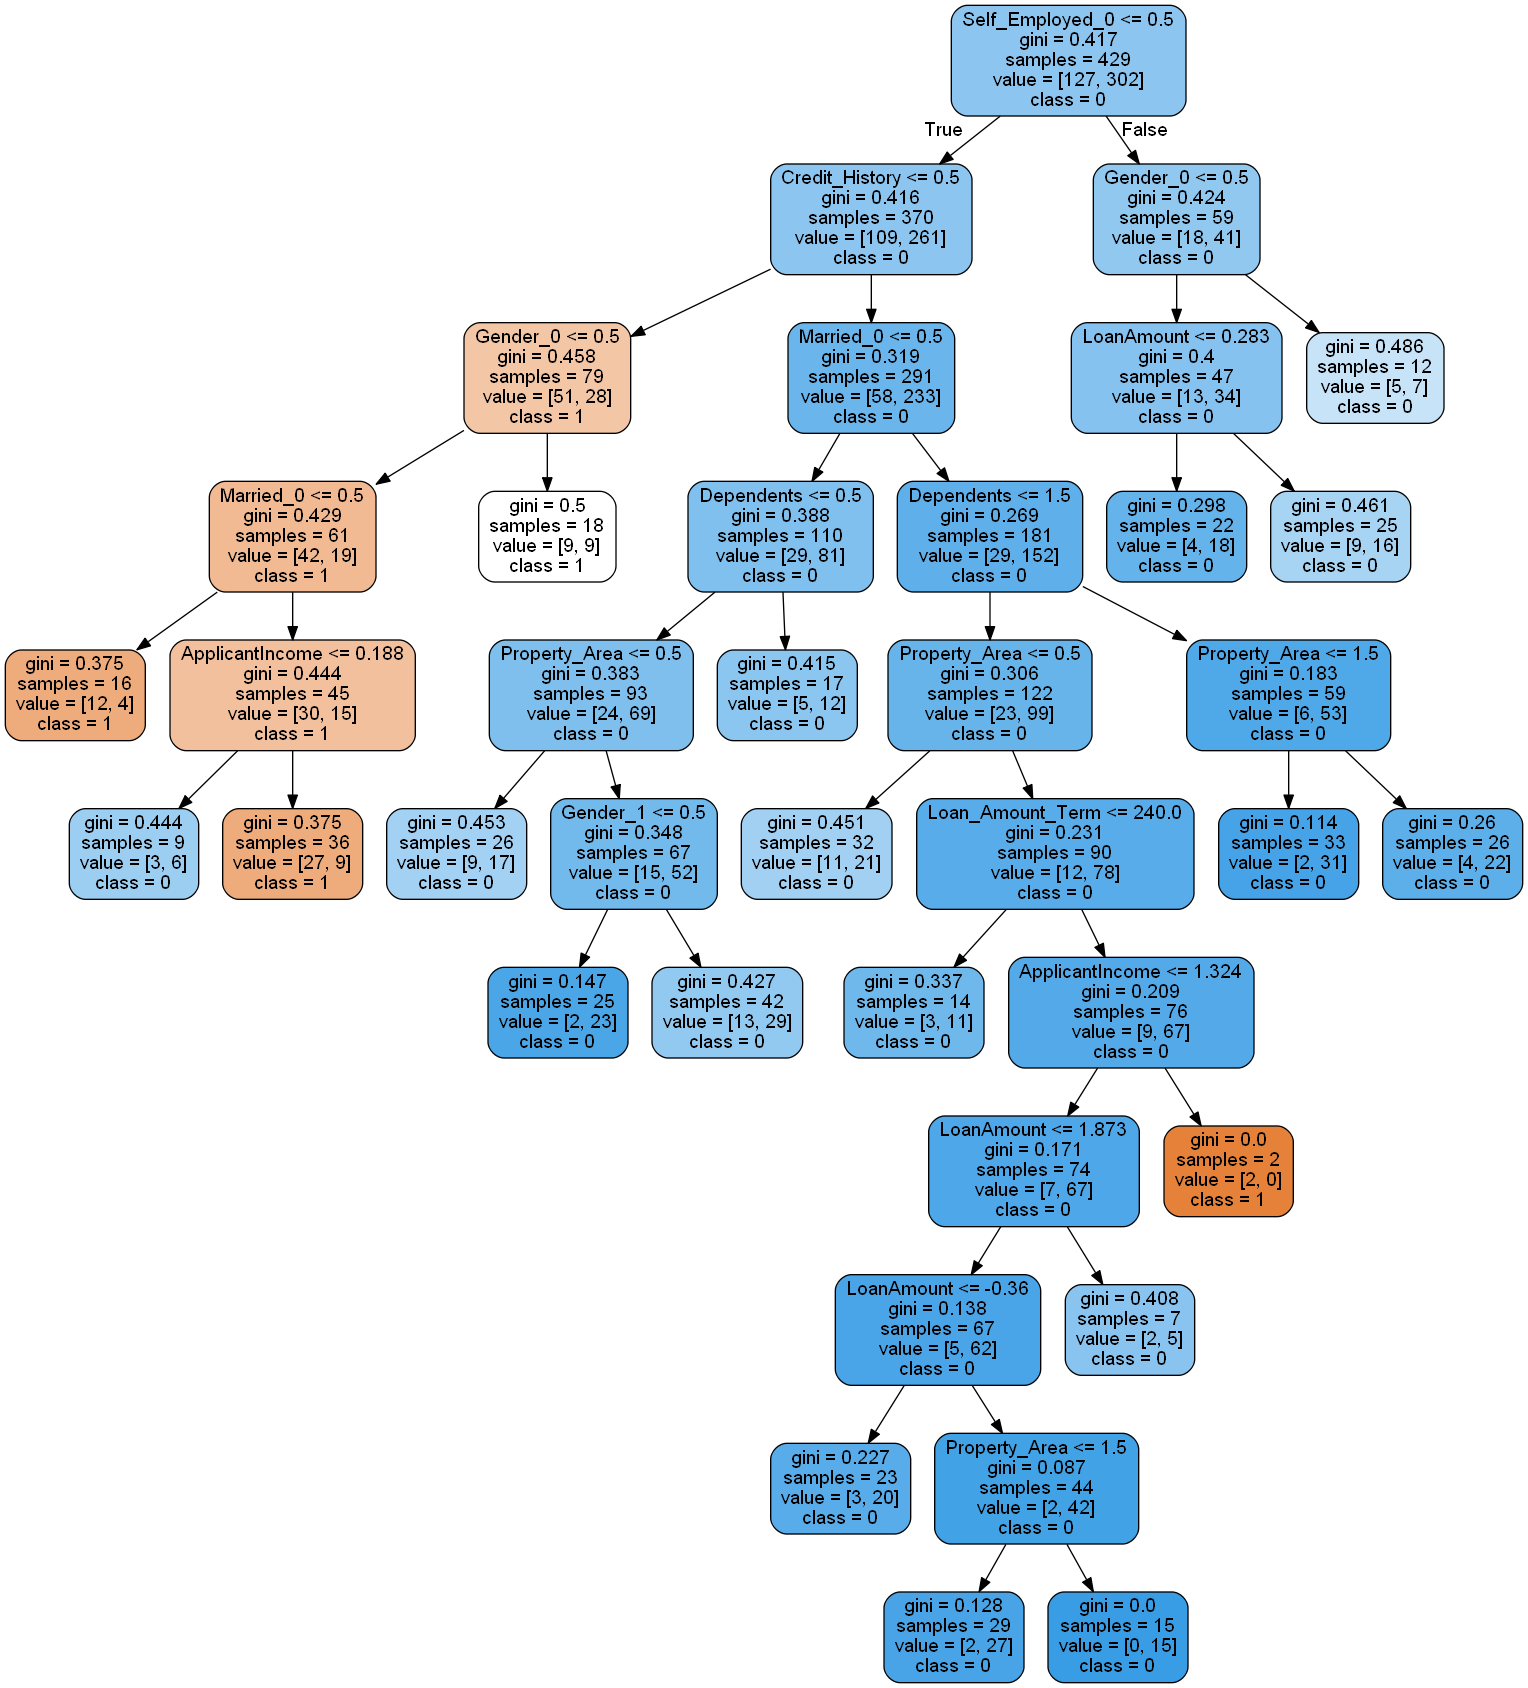

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import pydotplus
from IPython.display import Image, display

DT=DecisionTreeClassifier(max_features=1, min_samples_split=0.1)
DT.fit(data_transformed_xtrain,y_train)
classes=list(DT.classes_)
print(DT)

## Plotting the Decision Tree
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
dot_data = tree.export_graphviz(DT, out_file=None,
                                    feature_names=data_transformed_xtrain.columns,
                                    class_names=['1','0'],
                                    filled=True, rounded=True)
 
graph = pydotplus.graph_from_dot_data(dot_data)
display(Image(data=graph.create_png()))